Results from SCARGC algorithm (for boxplot and accuracy timelime).
Two Rotating Gears (Two classes. Bidimensional).
100 batches of 1999 instances



METHOD: K-NN as classifier (Updating)
Average execution time:  10.4799170212
Average Accuracy:  88.392196098
Standard Deviation:  3.56637236307
Variance:  12.7190118321


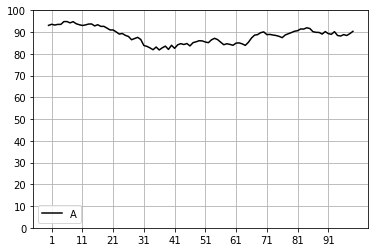

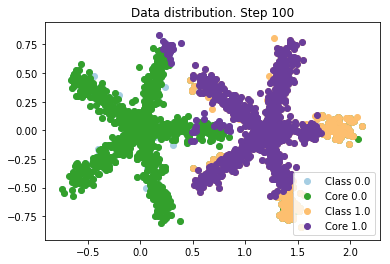




METHOD: K-NN as classifier and kde as core support extraction with cutting data method
Average execution time:  32.2060718665
Average Accuracy:  96.0710355178
Standard Deviation:  0.634999309698
Variance:  0.403224123317


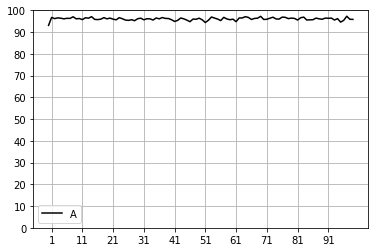

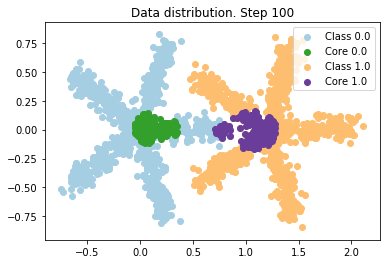




SCARGC
Average Accuracy:  98.2220590295
Standard Deviation:  0.299603302375
Variance:  0.0897621387943


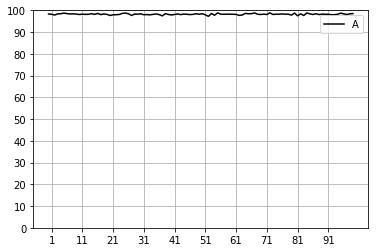

Boxplots from all methods


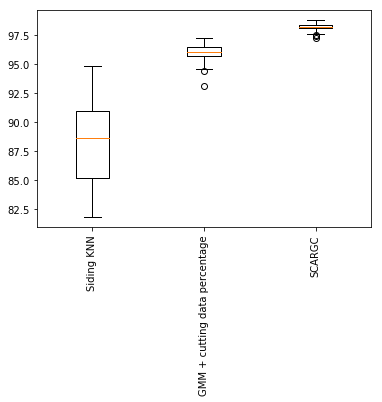

In [1]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[3])

import setup
from methods import runExperiments
from methods import static_labelpropagation
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import scargc_1NN


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = 300
    isBatchMode = False # False = Stream
    isBinaryClassification = True
    isImbalanced = False
    externalResults = {}
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadGEARS_2C_2D(path, sep)
    
    # Only 5% of initial labeled data - Extreme verification latency scenario
    labeledData = 50 #int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_labelpropagation, 6, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 6, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 6, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 6, 0.7, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    experiments[4] = Experiment(amanda_dynamic, 6, None, "kde", sslClassifier)

    # SCARGC 1NN (Python version)
    experiments[5] = Experiment(scargc_1NN, 5) 
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()